In [102]:
%load_ext autoreload
%autoreload 2
from ASD_Circuits import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [105]:
type("AA") == "str"

False

In [106]:
isinstance("SS", str)

True

In [108]:
SSC_struct_rank_fil = "dat/bias/asd.ssc.zmatch.rank.csv"
g, top_structs = LoadConnectome(SSC_struct_rank_fil, Bin=True)
top_nodes = g.vs.select(label_in=top_structs)
g2 = g.subgraph(top_nodes)

In [109]:
print(g.vcount(), g.ecount())
print(g2.vcount(), g2.ecount())

213 3062
50 190


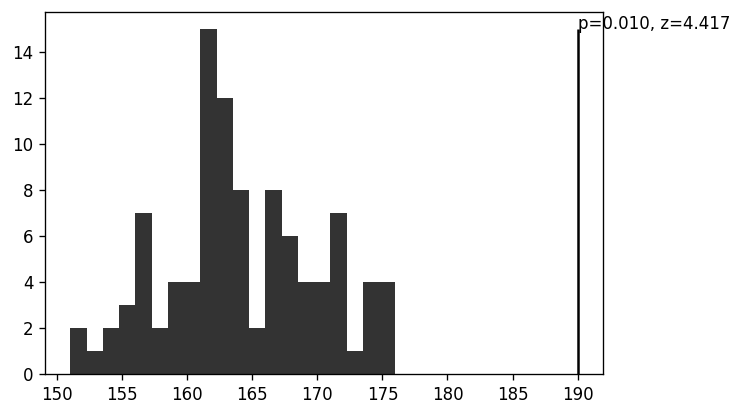

In [110]:
edge_permute_stat = g2.ecount()
g2_ecounts = EdgePermutation(g, top_nodes, edge_permute_stat, Npermute=100)
PlotPermutationP(g2_ecounts, edge_permute_stat)

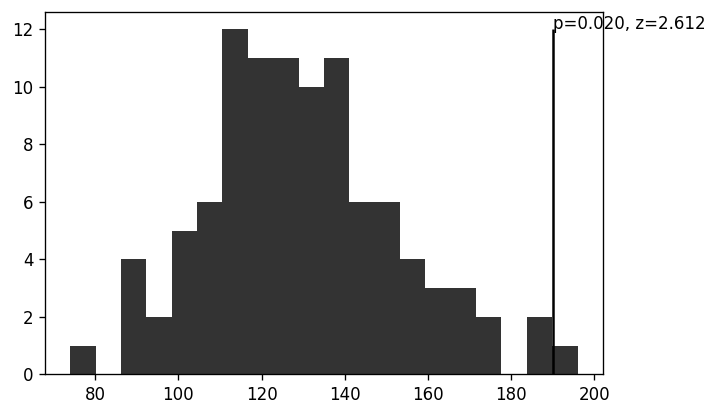

In [111]:
#node_permute_stat = Cohesiveness(g, idx_top50nodes, TopN=1)
node_permute_stat = g2.ecount()
node_null = NodePermutation(g, top_nodes, node_permute_stat, Npermute=100)
PlotPermutationP(node_null, node_permute_stat)

In [112]:
NodePermutationBinom(g, 50, g2, Npermute=100, mode="Random")

(190, 2450, 0.054820408163265305, 2.951597677057704e-06)

In [113]:
190 / 2450

0.07755102040816327

In [114]:
NodePermutationBinom(g, 50, g2, Npermute=100, mode="Region")

(190, 2450, 0.05423673469387755, 1.3657554278274261e-06)

In [115]:
NodePermutationBinom(g, 50, g2, Npermute=100, mode="Percent")

(190, 1256, 0.10090996686909733, 2.7852442450990105e-08)

In [116]:
190/1256

0.15127388535031847

In [117]:
SSC_struct_rank_fil = "dat/bias/asd.tada.zmatch.rank.csv"
g, top_structs = LoadConnectome(SSC_struct_rank_fil, Bin=True)
top_nodes = g.vs.select(label_in=top_structs)
g2 = g.subgraph(top_nodes)

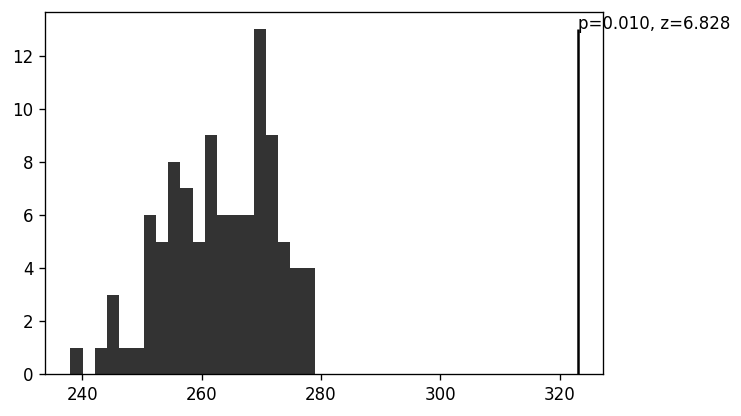

In [118]:
edge_permute_stat = g2.ecount()
g2_ecounts = EdgePermutation(g, top_nodes, edge_permute_stat, Npermute=100)
PlotPermutationP(g2_ecounts, edge_permute_stat)

In [119]:
NodePermutationBinom(g, 50, g2, Npermute=100, mode="Random")

(323, 2450, 0.05339591836734695, 5.138167706058472e-49)

In [120]:
NodePermutationBinom(g, 50, g2, Npermute=100, mode="Region")

(323, 2450, 0.07217551020408164, 4.767966478248732e-25)

In [121]:
NodePermutationBinom(g, 50, g2, Npermute=100, mode="Percent")

(323, 1631, 0.10111146323629569, 2.31635947121556e-31)

In [122]:
SSC_struct_rank_fil = "dat/bias/asd.spark.zmatch.rank.csv"
g, top_structs = LoadConnectome(SSC_struct_rank_fil, Bin=True)
top_nodes = g.vs.select(label_in=top_structs)
g2 = g.subgraph(top_nodes)

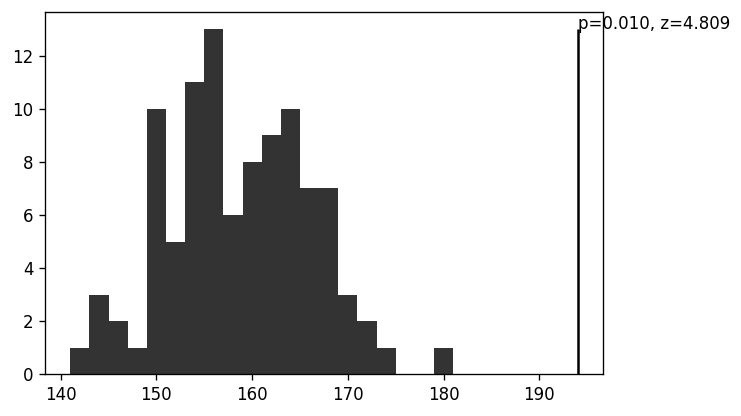

In [123]:
edge_permute_stat = g2.ecount()
g2_ecounts = EdgePermutation(g, top_nodes, edge_permute_stat, Npermute=100)
PlotPermutationP(g2_ecounts, edge_permute_stat)

In [124]:
NodePermutationBinom(g, 50, g2, Npermute=100, mode="Random")

(194, 2450, 0.053493877551020405, 1.058719828709715e-07)

In [125]:
NodePermutationBinom(g, 50, g2, Npermute=100, mode="Region")

(194, 2450, 0.05678775510204082, 5.327317291322536e-06)

In [126]:
NodePermutationBinom(g, 50, g2, Npermute=100, mode="Percent")

(194, 1315, 0.10217591965716462, 3.0693220644781734e-07)

In [127]:
194 / 1315

0.14752851711026616

In [128]:
STR2REG, REG2STR = LoadSTR2REG()

In [129]:
for i, row in pd.read_csv(SSC_struct_rank_fil).iterrows():
    str_ = row["STR"]
    print(str_)
    

Accessory_olfactory_bulb
Dentate_gyrus
Anterior_olfactory_nucleus
Infralimbic_area
Dorsal_peduncular_area
Frontal_pole_cerebral_cortex
Lateral_posterior_nucleus_of_the_thalamus
Lateral_septal_nucleus_rostral_rostroventral_part
Orbital_area_ventrolateral_part
Field_CA1
Main_olfactory_bulb
Caudoputamen
Nucleus_accumbens
Endopiriform_nucleus_dorsal_part
Field_CA2
Claustrum
Lateral_septal_nucleus_caudal_caudodorsal_part
Retrosplenial_area_lateral_agranular_part
Taenia_tecta
Orbital_area_lateral_part
Field_CA3
Secondary_motor_area
Lateral_habenula
Prelimbic_area
Lateral_septal_nucleus_ventral_part
Fundus_of_striatum
Agranular_insular_area_ventral_part
Triangular_nucleus_of_septum
Orbital_area_medial_part
Intercalated_amygdalar_nucleus
Anterior_cingulate_area_dorsal_part
Parataenial_nucleus
Ansiform_lobule
Bed_nuclei_of_the_stria_terminalis
Pyramus_VIII
Posterior_amygdalar_nucleus
Central_amygdalar_nucleus
Anterior_pretectal_nucleus
Paraventricular_nucleus_of_the_thalamus
Anterior_cingulate_

In [130]:
jon_ssc_level = pd.read_csv("dat/bias/jon_bias/zscore-vs_match-ssc-1.csv")
jon_ssc_spec = pd.read_csv("dat/bias/jon_bias/zscore-vs_match-ssc-2.csv")
jon_spark_level = pd.read_csv("dat/bias/jon_bias/zscore-vs_match-spark-1.csv")
jon_spark_spec = pd.read_csv("dat/bias/jon_bias/zscore-vs_match-spark-2.csv")
jon_tada_level = pd.read_csv("dat/bias/jon_bias/zscore-vs_match-tada-1.csv")
jon_tada_spec = pd.read_csv("dat/bias/jon_bias/zscore-vs_match-tada-2.csv")

In [142]:
g, top_structs = LoadConnectome(jon_ssc_level, Bin=True)
ssc_level_top_nodes = g.vs.select(label_in=top_structs)
g_ssc_level = g.subgraph(ssc_level_top_nodes)

139


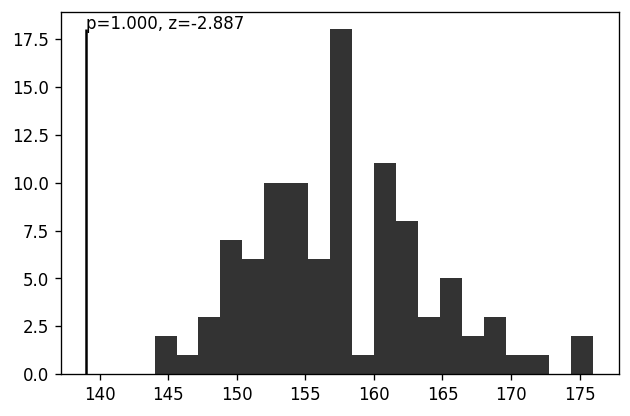

In [143]:
edge_permute_stat = g_ssc_level.ecount()
print(edge_permute_stat)
g_ssc_level_ecounts = EdgePermutation(g, top_nodes, edge_permute_stat, Npermute=100)
PlotPermutationP(g_ssc_level_ecounts, edge_permute_stat)

In [144]:
x, n, r, p = NodePermutationBinom(g, 50, g_ssc_level, Npermute=100, mode="Random")
print("Random %d %d %.4f %.4f %.2e"%(x, n, x/n, r, p))
x, n, r, p = NodePermutationBinom(g, 50, g_ssc_level, Npermute=100, mode="Random")
print("Region %d %d %.4f %.4f %.2e"%(x, n, x/n, r, p))
x, n, r, p = NodePermutationBinom(g, 50, g_ssc_level, Npermute=100, mode="Percent")
print("Percent %d %d %.4f %.4f %.2e"%(x, n, x/n, r, p))

Random 139 2450 0.0567 0.0559 8.60e-01
Region 139 2450 0.0567 0.0542 5.62e-01
Percent 139 1125 0.1236 0.1026 2.36e-02


In [145]:
g, top_structs = LoadConnectome(jon_spark_level, Bin=True)
spark_level_top_nodes = g.vs.select(label_in=top_structs)
g_spark_level = g.subgraph(spark_level_top_nodes)

189


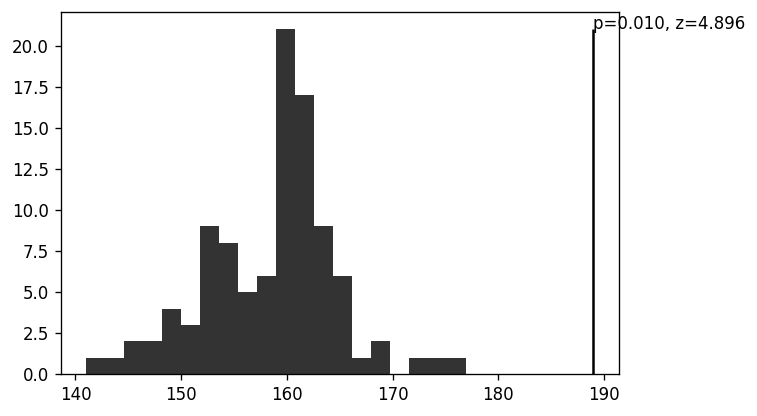

In [146]:
edge_permute_stat = g_spark_level.ecount()
print(edge_permute_stat)
g_spark_level_ecounts = EdgePermutation(g, top_nodes, edge_permute_stat, Npermute=100)
PlotPermutationP(g_spark_level_ecounts, edge_permute_stat)

In [147]:
x, n, r, p = NodePermutationBinom(g, 50, g_spark_level, Npermute=100, mode="Random")
print("Random %d %d %.4f %.4f %.2e"%(x, n, x/n, r, p))
x, n, r, p = NodePermutationBinom(g, 50, g_spark_level, Npermute=100, mode="Random")
print("Region %d %d %.4f %.4f %.2e"%(x, n, x/n, r, p))
x, n, r, p = NodePermutationBinom(g, 50, g_spark_level, Npermute=100, mode="Percent")
print("Percent %d %d %.4f %.4f %.2e"%(x, n, x/n, r, p))

Random 189 2450 0.0771 0.0531 5.27e-07
Region 189 2450 0.0771 0.0529 3.93e-07
Percent 189 1225 0.1543 0.1017 1.18e-08


In [150]:
len(set(jon_ssc_level.head(50)["STRUC"].values).intersection(jon_spark_level.head(50)["STRUC"].values))

38

In [153]:
def run_connectivity_tests(str_rank, ):
    g, top_structs = LoadConnectome(str_rank, Bin=True)
    top_nodes = g.vs.select(label_in=top_structs)
    g2 = g.subgraph(top_nodes)

    print("Edge Permutation Test")
    edge_permute_stat = g2.ecount()
    print("N edges:", edge_permute_stat)
    g2_ecounts = EdgePermutation(g, top_nodes, edge_permute_stat, Npermute=100)
    PlotPermutationP(g2_ecounts, edge_permute_stat)
    
    print("Node Permutation Test")
    x, n, r, p = NodePermutationBinom(g, 50, g2, Npermute=100, mode="Random")
    print("Random %d %d %.4f %.4f %.2e"%(x, n, x/n, r, p))
    x, n, r, p = NodePermutationBinom(g, 50, g2, Npermute=100, mode="Random")
    print("Region %d %d %.4f %.4f %.2e"%(x, n, x/n, r, p))
    x, n, r, p = NodePermutationBinom(g, 50, g2, Npermute=100, mode="Percent")
    print("Percent %d %d %.4f %.4f %.2e"%(x, n, x/n, r, p))

Edge Permutation Test
N edges: 139


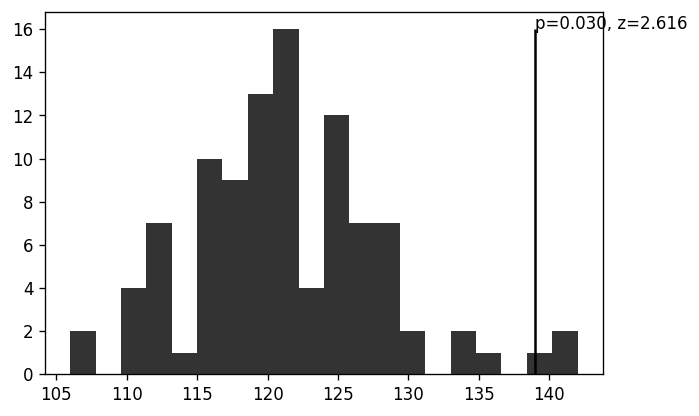

Node Permutation Test
Random 139 2450 0.0567 0.0545 6.24e-01
Region 139 2450 0.0567 0.0554 7.57e-01
Percent 139 1125 0.1236 0.1009 1.33e-02


In [155]:
run_connectivity_tests(jon_ssc_level)

In [174]:
jw_ssc_level = pd.read_csv("dat/bias/ssc.explevel.rank.tsv")
jw_spark_level = pd.read_csv("dat/bias/spark.explevel.rank.tsv")
jw_tada_level = pd.read_csv("dat/bias/tada.explevel.rank.tsv")

Edge Permutation Test
N edges: 204


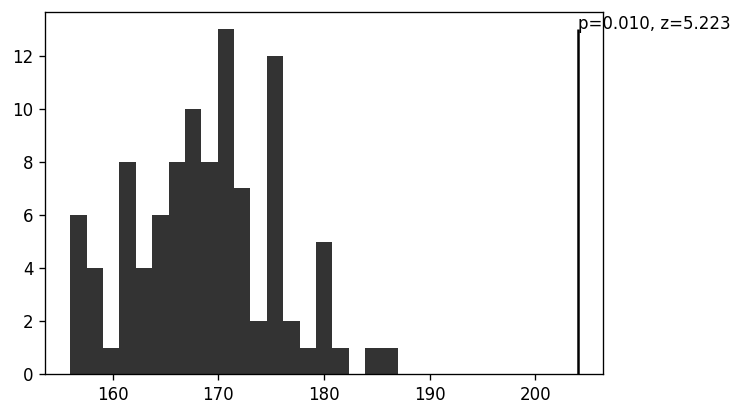

Node Permutation Test
Random 204 2450 0.0833 0.0525 2.41e-10
Region 204 2450 0.0833 0.0539 2.28e-09
Percent 204 1251 0.1631 0.1017 2.30e-11


In [162]:
run_connectivity_tests(jw_ssc_level)

Edge Permutation Test
N edges: 174


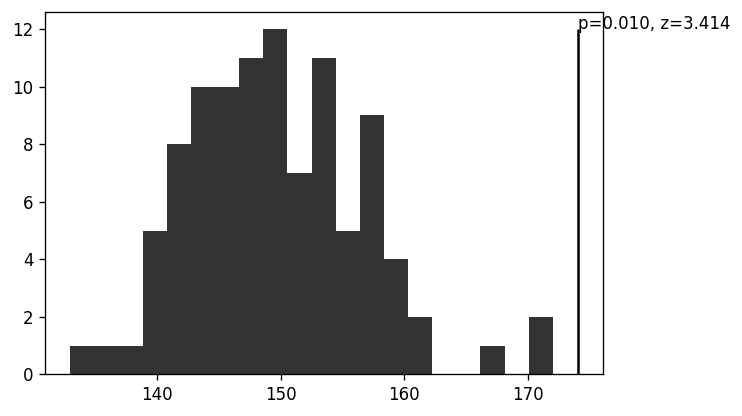

Node Permutation Test
Random 174 2450 0.0710 0.0531 1.48e-04
Region 174 2450 0.0710 0.0560 1.78e-03
Percent 174 1214 0.1433 0.1004 2.64e-06


In [178]:
run_connectivity_tests(jw_spark_level)

In [163]:
len(set(jon_ssc_level.head(50)["STRUC"].values).intersection(jw_ssc_level.head(50)["STR"].values))

42

In [175]:
#top_nodes = g.vs.select(label_in=top_structs)
#g2 = g.subgraph(top_nodes)
g_jon_ssc_level = g.subgraph(g.vs.select(label_in=jon_ssc_level.head(50)["STRUC"].values))
g_jon_spark_level = g.subgraph(g.vs.select(label_in=jon_spark_level.head(50)["STRUC"].values))
g_jon_tada_level = g.subgraph(g.vs.select(label_in=jon_tada_level.head(50)["STRUC"].values))
g_jw_ssc_level = g.subgraph(g.vs.select(label_in=jw_ssc_level.head(50)["STR"].values))
g_jw_spark_level = g.subgraph(g.vs.select(label_in=jw_spark_level.head(50)["STR"].values))
g_jw_tada_level = g.subgraph(g.vs.select(label_in=jw_tada_level.head(50)["STR"].values))

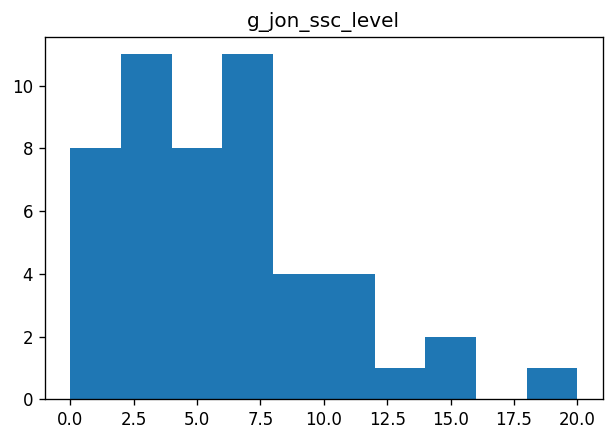

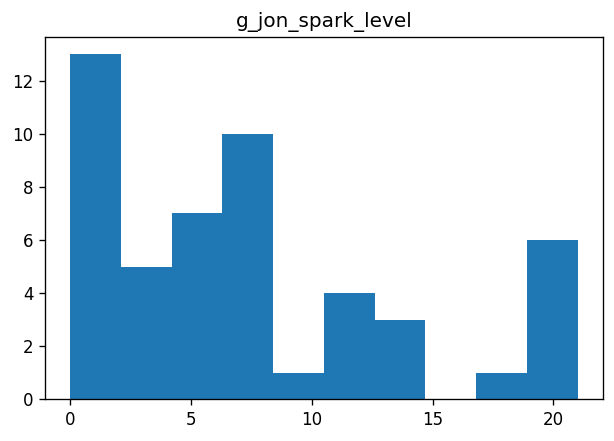

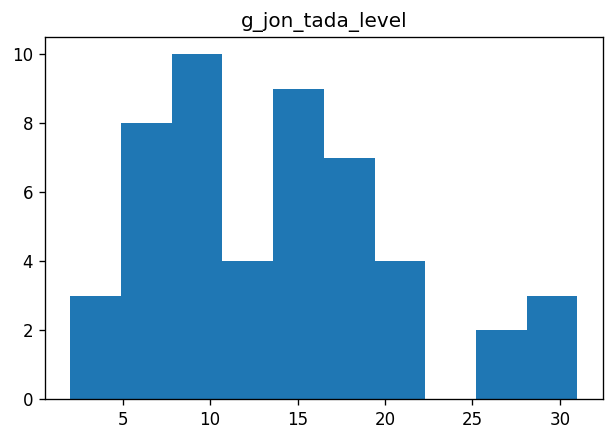

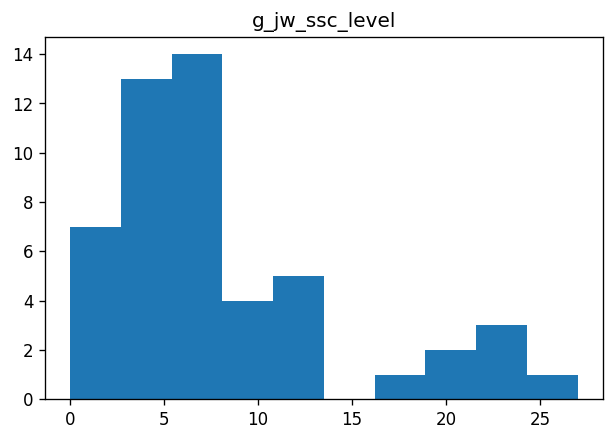

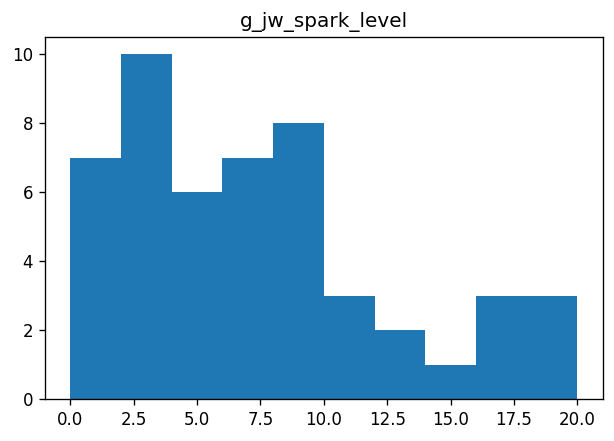

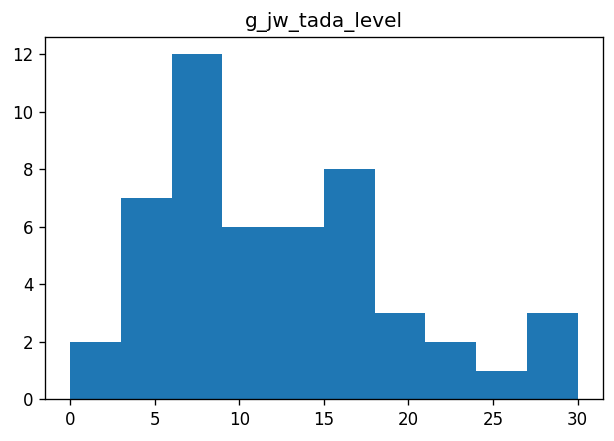

In [177]:
for i, (name, gg) in enumerate(zip(["g_jon_ssc_level", "g_jon_spark_level", "g_jon_tada_level", 
                                 "g_jw_ssc_level", "g_jw_spark_level", "g_jw_tada_level"], 
                                [g_jon_ssc_level, g_jon_spark_level, g_jon_tada_level, 
                                 g_jw_ssc_level, g_jw_spark_level, g_jw_tada_level])):
    plt.hist(gg.degree())
    plt.title(name)
    plt.show()

(array([ 8., 11.,  8., 11.,  4.,  4.,  1.,  2.,  0.,  1.]),
 array([ 0.,  2.,  4.,  6.,  8., 10., 12., 14., 16., 18., 20.]),
 <a list of 10 Patch objects>)

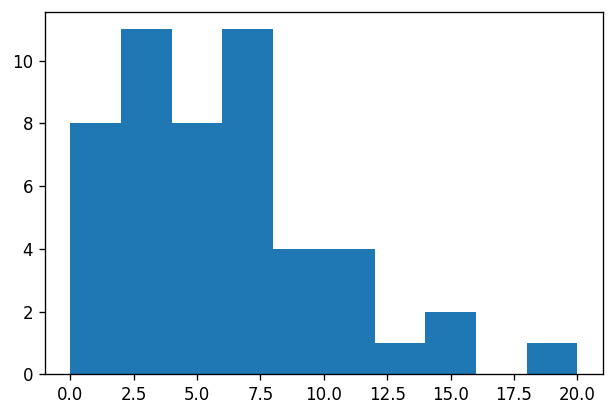

In [166]:
plt.hist(g_jon_ssc_level.degree())

In [187]:
for v in g_jw_ssc_level.vs:
    print(v["label"], v.degree())

Anterior_cingulate_area_dorsal_part 27
Anterior_cingulate_area_ventral_part 8
Nucleus_accumbens 7
Anteromedial_nucleus_dorsal_part 13
Anteromedial_nucleus_ventral_part 10
Accessory_olfactory_bulb 5
Anterior_olfactory_nucleus 7
Anterior_pretectal_nucleus 5
Field_CA1 5
Field_CA2 8
Field_CA3 9
Central_lateral_nucleus_of_the_thalamus 6
Claustrum 20
Central_medial_nucleus_of_the_thalamus 4
Caudoputamen 6
Dentate_gyrus 5
Dorsal_peduncular_area 7
Frontal_pole_cerebral_cortex 7
Inferior_colliculus_central_nucleus 0
Infralimbic_area 22
Intermediodorsal_nucleus_of_the_thalamus 7
Lateral_habenula 1
Lateral_posterior_nucleus_of_the_thalamus 5
Lateral_septal_nucleus_caudal_caudodorsal_part 3
Lateral_septal_nucleus_rostral_rostroventral_part 5
Lateral_septal_nucleus_ventral_part 1
Mediodorsal_nucleus_of_thalamus 12
Medial_geniculate_complex_medial_part 3
Medial_habenula 0
Main_olfactory_bulb 2
Secondary_motor_area 22
Nucleus_of_the_optic_tract 9
Orbital_area_lateral_part 19
Orbital_area_ventrolatera

In [211]:
g_jw_ssc_level.vs.find(label="Anterior_cingulate_area_dorsal_part").degree()

27

In [212]:
g.vs.find(label="Anterior_cingulate_area_dorsal_part").degree()

66

In [214]:
print(27/66, 50/213)

0.4090909090909091 0.2347417840375587


In [201]:
def MakeConsensus(gs, g, names, topN=50):
    all_strs, all_str_names = [], []
    for g_ in gs:
        for v in g_.vs:
            all_strs.append(v['label'])
    all_strs = list(set(list(all_strs)))
    dat = []
    for str_ in all_strs:
        row = []
        for g_ in gs:
            try:
                row.append(g_.vs.find(label=str_).degree())
            except:
                row.append(0)
        dat.append(row)
    df = pd.DataFrame(data=dat, columns = names, index=all_strs)
    return df

In [204]:
gs = [g_jon_ssc_level, g_jon_spark_level, g_jon_tada_level, g_jw_ssc_level, g_jw_spark_level, g_jw_tada_level]
names = ["g_jon_ssc_level", "g_jon_spark_level", "g_jon_tada_level", "g_jw_ssc_level", "g_jw_spark_level", "g_jw_tada_level"]
df = MakeConsensus(gs, g, names)
df.index.name = "STRUCT"
df.to_csv("dat/degrees.csv")

In [203]:
df

,g_jon_ssc_level,g_jon_spark_level,g_jon_tada_level,g_jw_ssc_level,g_jw_spark_level,g_jw_tada_level
Main_olfactory_bulb,2,2,2,2,2,3
Dorsal_auditory_area,0,0,15,0,0,13
Endopiriform_nucleus_dorsal_part,0,4,6,0,4,5
Primary_somatosensory_area_barrel_field,0,0,19,0,0,16
Primary_motor_area,0,0,17,0,0,16
...,...,...,...,...,...,...
Anterior_cingulate_area_dorsal_part,0,20,29,27,20,27
Field_CA3,9,9,7,9,8,7
Prelimbic_area,11,13,9,12,10,7
Central_lateral_nucleus_of_the_thalamus,3,4,0,6,0,0


In [215]:
g_jon_ssc_level.is_directed()

True